# Analysis of models

Perform the imports

In [4]:
import pickle
from os.path import exists
from random import shuffle
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
from rich import print
from rich.panel import Panel
from rich.progress import track
from rich.traceback import install
from scipy.special import softmax
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.svm import SVC
from tqdm import tqdm

from console import console
from feature_extraction import miles_cw_extractor
from models import example_model, svm_implementation, svm_model
from preprocessing import get_data, preprocess

install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7fbaf1ac8640>>

Either load a pre-trained SVM from disk or train a new one

In [5]:
if exists("checkpoint.p"):
    console.log("Checkpoint found in FS")
    with console.status("Loading checkpoint from file...", spinner="aesthetic"):
        svm_model, tfid, vectorizer, get_best= pickle.load(open("checkpoint.p", "rb"))
else:
    svm_model, tfid, vectorizer, get_best = svm_implementation()
    with console.status("Saving checkpoint to file...", spinner="aesthetic"):
        pickle.dump((svm_model, tfid, vectorizer, get_best), open("checkpoint.p", "wb" ))

[11:55:10] Checkpoint found in FS                            <ipython-input-5-f9973be1354e>:2

Output()

Load the pretrained model

In [6]:
with console.status("Loading example model...", spinner="aesthetic"): 
        model, tokenizer, labels = example_model()

Output()

In [7]:
# analysis()


╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-7-5300f5cd80da>:1 in <module>                                              │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'analysis' is not defined

Get the validation data from disk

In [8]:
v_x, v_y = get_data("val", False)

Predict the $Y$ values using the SVM

In [9]:
Y_text_predictions_SVM = svm_model.predict(get_best.transform(
    tfid.transform(
        vectorizer.transform(v_x)
        ).toarray()
    )
)

And produce a report

In [10]:
print(classification_report(v_y, Y_text_predictions_SVM))


precision    recall  f1-score   support

           0       0.42      0.64      0.50       312
           1       0.62      0.61      0.61       869
           2       0.73      0.60      0.66       819

    accuracy                           0.61      2000
   macro avg       0.59      0.61      0.59      2000
weighted avg       0.63      0.61      0.61      2000

Do the same for the provided model

In [11]:
Y_text_predictions = []


In [12]:
for tweet in tqdm(v_x):
    encoded_input = tokenizer(tweet, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    prediction = ranking[0]
    Y_text_predictions.append(prediction)

100%|██████████| 2000/2000 [02:05<00:00, 15.99it/s]


In [13]:
print(classification_report(v_y, Y_text_predictions))

precision    recall  f1-score   support

           0       0.71      0.83      0.77       312
           1       0.78      0.79      0.79       869
           2       0.88      0.81      0.85       819

    accuracy                           0.81      2000
   macro avg       0.79      0.81      0.80      2000
weighted avg       0.81      0.81      0.81      2000

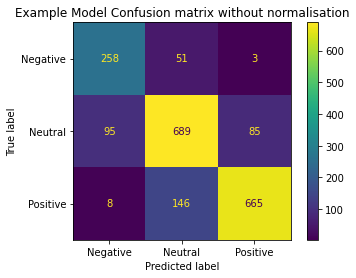

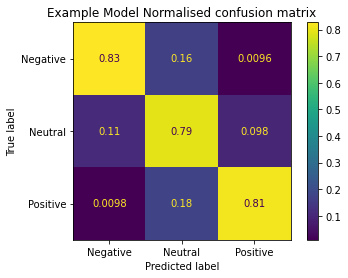

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

titles_options = [("Example Model Confusion matrix without normalisation", None),
                  ("Example Model Normalised confusion matrix", 'true')]
display_labels = ['Negative','Neutral','Positive']
labels = [0,1,2]
for title, normalize in titles_options:
  cm = confusion_matrix(v_y, Y_text_predictions, labels=labels, normalize=normalize)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
  disp.plot()
  disp.ax_.set_title(title)


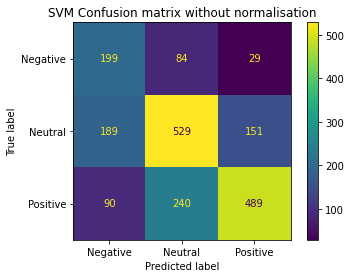

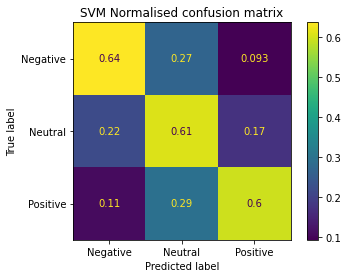

In [21]:
titles_options = [("SVM Confusion matrix without normalisation", None),
                  ("SVM Normalised confusion matrix", 'true')]
display_labels = ['Negative','Neutral','Positive']
labels = [0,1,2]
for title, normalize in titles_options:
  cm = confusion_matrix(v_y, Y_text_predictions_SVM, labels=labels, normalize=normalize)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
  disp.plot()
  disp.ax_.set_title(title)
